#### Import calls

In [1]:
import distutils.util
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# import from other python files
from pend_utils import pd_control
# from cane_builder import CaneEditor

BROWN = np.array([0.4, 0.24, 0.0, 1])

#### Let's build the tree!

In [ ]:
branch_model = """
<mujoco model="single_pendulum_connected_hinge">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch with attached probe -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0" stiffness="295" springref="0" damping="0.15"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1"/>
      
     <!-- probe anchor at probe tip, fixed to world -->
      <body name="probe_anchor" pos="-0.117 0 .75">
        <!-- identical green cylinder at anchor -->
        <geom size="0.005 0.075" pos="0.025 0 0" quat="0.707107 0 0.707106 0" type="cylinder" rgba="0 1 0 1"/>
        <!-- slide joint between anchor and probe_link -->
        <joint name="probe_joint" pos="0 0 0" axis="1 0 0" type="slide" range="0 0.045"/>
        <!-- probe_link is now a child of probe_anchor -->
        <body name="probe_link" pos="0 0 0">
          <inertial pos="0.0801087 0 0" quat="0 0.707107 0 0.707107" mass="0.115" diaginertia="0.0230877 0.0230846 0.0230031"/>
          <joint name="probe_hinge" type="hinge" axis="0 1 0" pos="0 0 0"/>
          <!-- identical red cylinder on probe -->
          <geom size="0.005 0.075" pos="0.025 0 0" quat="0.707107 0 0.707106 0" type="cylinder" rgba="1 0 0 1"/>
          <geom size="0.01 0.01 0.01" pos="0.1 0 0" type="box" rgba="1 0 0 1"/>
          <geom size="0.005 0.0175" pos="0.0975 0 0" quat="0.707107 0.707106 0 0" type="cylinder" rgba="1 0 0 1"/>
          <geom size="0.005 0.025" pos="0.1225 0.0175 0" quat="0.704433 -0.0614407 0.704432 0.0614408" type="cylinder" rgba="1 0 0 1"/>
          <geom size="0.005 0.025" pos="0.1225 -0.0175 0" quat="0.704433 0.0614407 0.704432 -0.0614408" type="cylinder" rgba="1 0 0 1"/>
        </body>
      </body>
    </body>
  </worldbody>

<actuator>
  <velocity name="probe_motor" joint="probe_joint" forcerange="-100 1000" kv="100000"/>
</actuator>

<equality>
    <!-- Weld the anchor to the world at its initial position -->
    <weld body1="probe_anchor" body2="world"/>
  </equality>

  <keyframe>
    <key name="initial" qpos="0 0 0" qvel="0 0 0" />
  </keyframe>
</mujoco>
"""

In [33]:
branch_model = """
<mujoco model="single_pendulum_connected_hinge">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <worldbody>
    <light name="top" pos="-.5 0 1.5"/>
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch with attached probe -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0" stiffness="295" springref="0" damping="0.15"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0 1 0 1"/>
      <!-- probe, attached to branch via hinge -->
      <body name="probe_link" pos="0 0 .75">
        <inertial pos="0.0801087 0 0" quat="0 0.707107 0 0.707107" mass="0.115" diaginertia="0.0230877 0.0230846 0.0230031"/>
        <joint name="probe_hinge" type="hinge" axis="0 1 0" pos="0 0 0"/>
        <!-- green cylinder at probe tip -->
        <geom name="probe_tip_geom" size="0.005 0.075" pos="-.075 0 0" quat="0.707107 0 0.707106 0" type="cylinder" rgba="1 0 0 1"/>
      </body>
    </body>

    <!-- anchor body at probe tip location, with identical blue cylinder -->
    <body name="probe_anchor" pos="-0.075 0 .75">
      <geom name="anchor_tip_geom" size="0.005 0.075" pos="0.0 0 0" quat="0.707107 0 0.707106 0" type="cylinder" rgba="0 0 1 1"/>
      <!-- slide joint between anchor and probe_link (closed loop) -->
      <joint name="probe_joint" type="slide" axis="1 0 0" pos="0 0 0" range="0 0.045"/>
    </body>
  </worldbody>

  <actuator>
    <velocity name="probe_motor" joint="probe_joint" forcerange="-100 1000" kv="100000"/>
  </actuator>

  <equality>
    <!-- Weld the anchor to the world at its initial position -->
    <weld body1="probe_anchor" body2="world"/>
    <!-- Connect the anchor and probe tip with a slide joint (closed loop) -->
    <connect body1="probe_anchor" body2="probe_link" anchor="-0.075 0 .75"/>
  </equality>

  <keyframe>
    <key name="initial" qpos="0 0 0" qvel="0 0 0" />
  </keyframe>
</mujoco>
"""

""

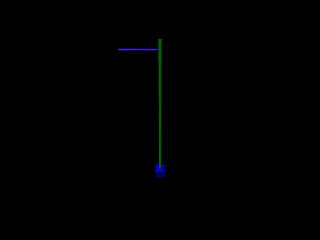

In [34]:
init_model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(init_model)
with mujoco.Renderer(init_model) as renderer:
    mujoco.mj_forward(init_model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

In [40]:
model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(model)

model.opt.timestep = .00001

duration = 5
framerate = 60
ctrl_speed = .001 # 1 mm/s

# Kp = np.array([295])
# Kd = np.array([.15])
init_angles = np.zeros(model.njnt)

timevals = []
posvals = []
velvals = []
forcevals = []
contact_x_forces = []

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    data.ctrl[0] = ctrl_speed
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    velvals.append(data.qvel.copy())
    forcevals.append(data.actuator_force.copy())

    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)
  

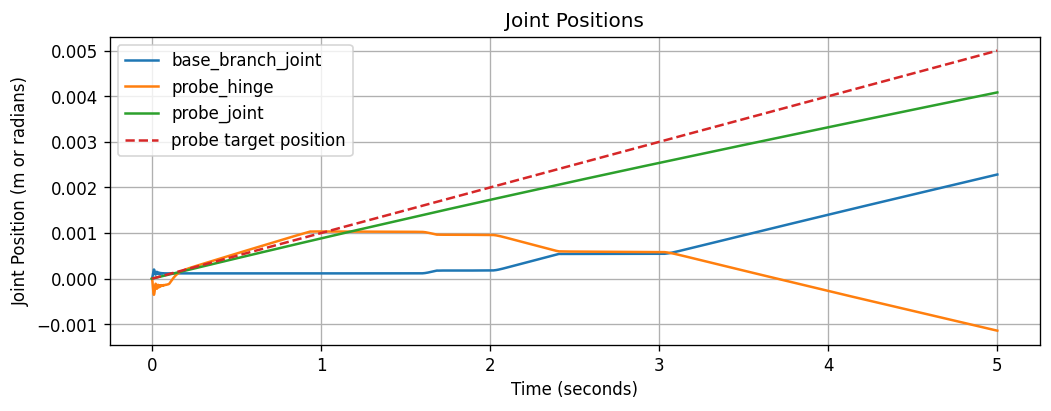

In [41]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

pos_array = np.array(posvals)  # shape: (timesteps, njnt)
  # shape: (timesteps, njnt)
for j in range(model.njnt):
    # Get joint name using the MuJoCo API
    joint_name = model.joint(j).name
    ax.plot(timevals, pos_array[:, j], label=joint_name)

ax.plot(timevals, np.array(timevals)*ctrl_speed, linestyle='--',label='probe target position')
ax.set_title("Joint Positions")
ax.set_ylabel("Joint Position (m or radians)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

filename = f"../images/plots/joint_positions_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
fig.savefig(filename)

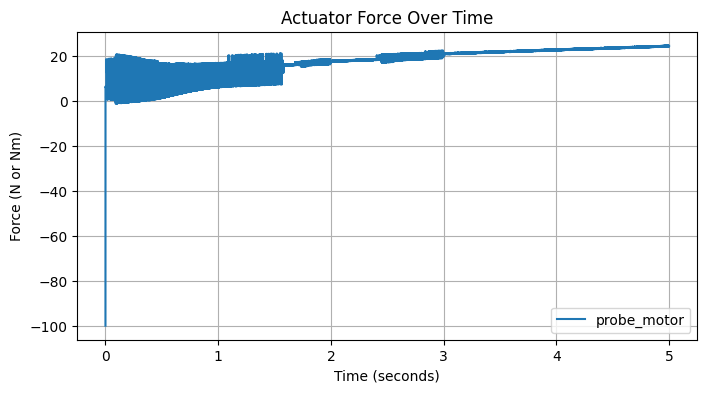

In [42]:
force_array = np.array(forcevals)  # shape: (timesteps, n_actuator)
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(model.nu):
    actuator_name = model.actuator(i).name
    ax.plot(timevals, force_array[:, i], label=actuator_name)
ax.set_title("Actuator Force Over Time")
ax.set_ylabel("Force (N or Nm)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

In [43]:
PROBE_HEIGHT = 0.75  # height of probe above branch in meters
branch_max_disp = pos_array[-1, 0] # branch displacement at the end of the run
print(f"Final branch displacement: {branch_max_disp:.3f} rad")
napkin_math_force = (295* branch_max_disp)/PROBE_HEIGHT
# napkin_math_force = (295* branch_max_disp + .15*branch_max_vel)/.75
print(f"Napkin math force: {napkin_math_force:.3f} N")
print(f"Final actuator force: {force_array[-1,0]:.3f} N")


Final branch displacement: 0.002 rad
Napkin math force: 0.899 N
Final actuator force: 24.404 N
